In [2]:
# basic imports
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
# display matplotlib graphics in notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
from sklearn.model_selection import train_test_split
import torch
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
import lightgbm as lgb


In [4]:
df_train = pd.read_csv('aclImdb/df_train')
X = df_train['comment']
y = df_train['sentiment']

In [5]:
device = torch.device(
    'cuda' if torch.cuda.is_available() 
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)
print(f'Using device: {device}')

Using device: cpu


In [6]:
def tokenize_review(text):
    # Nettoyage minimal et tokenisation (mots uniquement)
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

# Tokeniser les reviews
tokenized_reviews = [tokenize_review(review) for review in tqdm(X)]


100%|██████████| 25000/25000 [00:03<00:00, 7245.30it/s]


In [7]:
class Word2VecReviewEmbedder:
    def __init__(self,
                 tokenized_reviews,
                 vector_size=100,
                 window=5,
                 min_count=2,
                 sg=1,
                 workers=4):
        
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.sg = sg
        self.workers = workers

        # Entrainement du modèle Word2Vec sur les reviews tokenisées
        self.model = Word2Vec(
            sentences=tokenized_reviews,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            sg=self.sg,
            workers=self.workers
        )
        self.wv = self.model.wv

    def embed_reviews(self, tokenized_reviews):
        embeddings = []

        for tokens in tqdm(tokenized_reviews, desc="Embedding reviews"):
            vectors = [self.wv[token] for token in tokens if token in self.wv]

            if vectors:
                embed = np.mean(vectors, axis=0)
            else:
                embed = np.zeros(self.vector_size, dtype=np.float32)

            embeddings.append(embed)

        return np.array(embeddings)


In [8]:
#get word2vec embeddings
word2vec_embedder = Word2VecReviewEmbedder(tokenized_reviews, vector_size=100, window=10)

X_embeddings = word2vec_embedder.embed_reviews(tokenized_reviews)
print(f"X_embeddings shape: {X_embeddings.shape}")

with open('aclImdb/embeddings/X_train_word2vec_embeddings.pkl', 'wb') as f:
    pickle.dump(X_embeddings, f)


Embedding reviews: 100%|██████████| 25000/25000 [00:25<00:00, 967.96it/s] 


X_embeddings shape: (25000, 100)


In [9]:
with open('aclImdb/embeddings/X_train_word2vec_embeddings.pkl', 'rb') as f:
    X_embeddings = pickle.load(f)

y = df_train['sentiment'].values

X_train, X_val, y_train, y_val = train_test_split(
    X_embeddings, y, test_size=0.2, random_state=42, stratify=y
)


In [10]:
# SVM training
clf = LinearSVC()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
print(f'Accuracy: {accuracy_score(y_val, y_pred):.4f}')
print(classification_report(y_val, y_pred))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.8870
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2500
           1       0.89      0.89      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



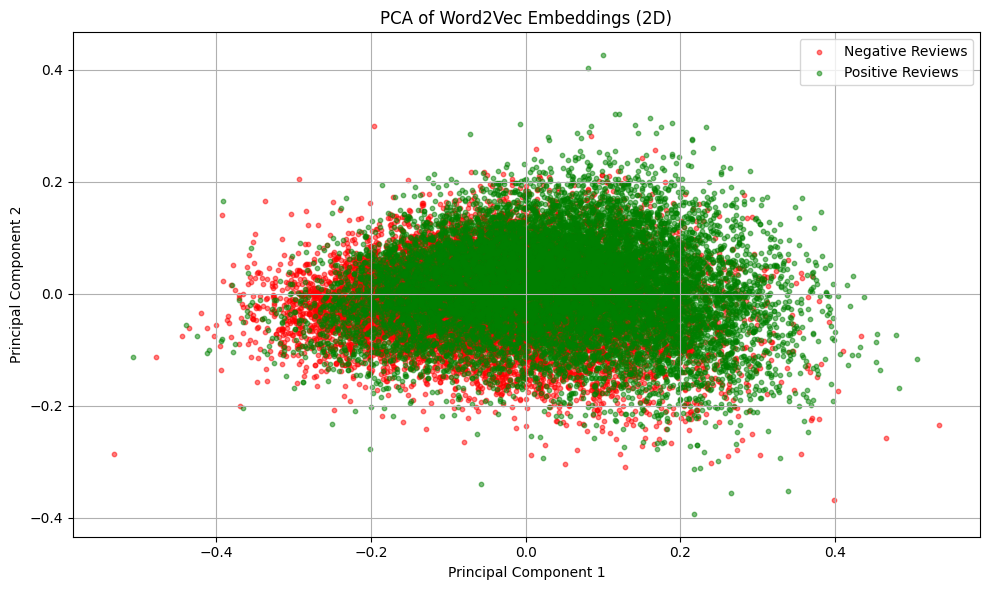

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X_embeddings)


plt.figure(figsize=(10, 6))
y = df_train['sentiment'].values
plt.scatter(X_reduced[y==0, 0], X_reduced[y==0, 1], 
            color='red', alpha=0.5, label='Negative Reviews', s=10)
plt.scatter(X_reduced[y==1, 0], X_reduced[y==1, 1], 
            color='green', alpha=0.5, label='Positive Reviews', s=10)

plt.title('PCA of Word2Vec Embeddings (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25000 samples in 0.003s...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[t-SNE] Computed neighbors for 25000 samples in 8.209s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25000
[t-SNE] Computed conditional probabilities for sample 2000 / 25000
[t-SNE] Computed conditional probabilities for sample 3000 / 25000
[t-SNE] Computed conditional probabilities for sample 4000 / 25000
[t-SNE] Computed conditional probabilities for sample 5000 / 25000
[t-SNE] Computed conditional probabilities for sample 6000 / 25000
[t-SNE] Computed conditional probabilities for sample 7000 / 25000
[t-SNE] Computed conditional probabilities for sample 8000 / 25000
[t-SNE] Computed conditional probabilities for sample 9000 / 25000
[t-SNE] Computed conditional probabilities for sample 10000 / 25000
[t-SNE] Computed conditional probabilities for sample 11000 / 25000
[t-SNE] Computed conditional probabilities for sample 12000 / 25000
[t-SNE] Computed conditional probabilities for sample 13000 / 25000
[t-SNE] Computed conditional probabilities for sample 14000 / 25000

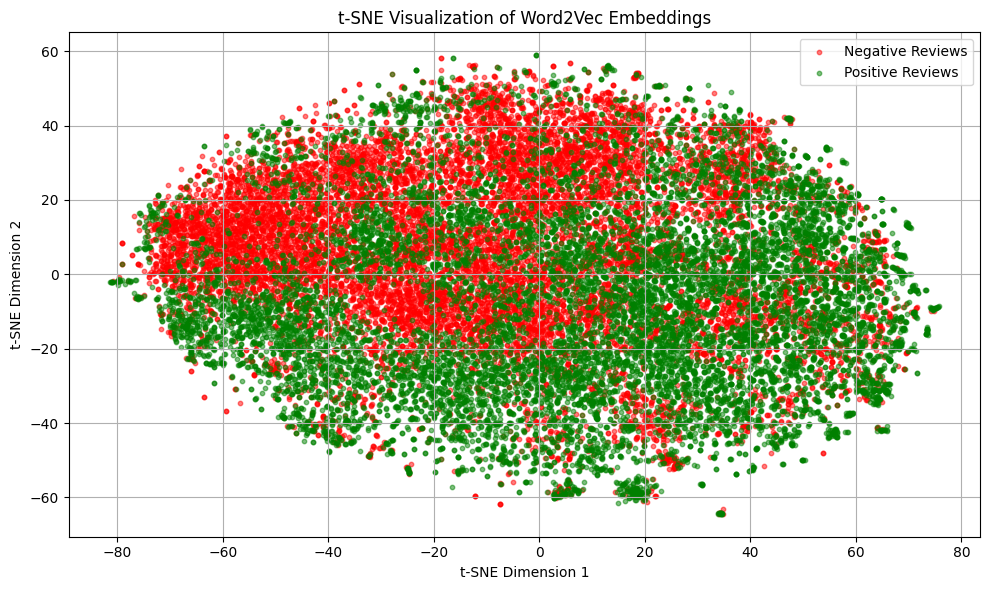

In [12]:
from sklearn.manifold import TSNE

# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, verbose=1)
X_tsne = tsne.fit_transform(X_embeddings)

# Visualisation
plt.figure(figsize=(10, 6))

y = df_train['sentiment'].values
plt.scatter(X_tsne[y==0, 0], X_tsne[y==0, 1], 
            color='red', alpha=0.5, label='Negative Reviews', s=10)
plt.scatter(X_tsne[y==1, 0], X_tsne[y==1, 1], 
            color='green', alpha=0.5, label='Positive Reviews', s=10)

plt.title('t-SNE Visualization of Word2Vec Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
